In [38]:
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import glob
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib

from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")

In [44]:
data_dir = "Dataset/"
all_images_dir = data_dir + "all_images 2/"
universal_test_dir = data_dir + "universal_test/"
combined_dir = data_dir + "combined/"

# Original separate directories
separate_dirs = {
    "COVID": os.path.join(data_dir, "COVID"),
    "NORMAL": os.path.join(data_dir, "NORMAL"),
    "PNEUMONIA": os.path.join(data_dir, "PNEUMONIA")
}

# Labels
data_labels = ["Tuberculosis", "NORMAL", "PNEUMONIA"]

# Create combined directory structure
for label in data_labels:
    os.makedirs(os.path.join(combined_dir, label), exist_ok=True)

# Function to copy images from source to destination
def copy_images(source_dir, label, destination_dir):
    src_path = os.path.join(source_dir, label)
    dest_path = os.path.join(destination_dir, label)
    if os.path.exists(src_path):
        for file_name in os.listdir(src_path):
            src_file = os.path.join(src_path, file_name)
            dest_file = os.path.join(dest_path, file_name)
            shutil.copy(src_file, dest_file)

# Copy images from all sources
for label in data_labels:
    print(f"Processing {label}...")
    copy_images(all_images_dir, label, combined_dir)
    copy_images(universal_test_dir, label, combined_dir)

# Copy images from the separate directories
for label, separate_dir in separate_dirs.items():
    print(f"Copying {label} from separate directory...")
    copy_images(separate_dir, label, combined_dir)


print("All images have been combined into:", combined_dir)

for label in data_labels:
    path = os.path.join(combined_dir, label)
    print(f"{label}: {len(os.listdir(path))} images")

Processing Tuberculosis...
Processing NORMAL...
Processing PNEUMONIA...
Copying COVID from separate directory...
Copying NORMAL from separate directory...
Copying PNEUMONIA from separate directory...
All images have been combined into: Dataset/combined/
Tuberculosis: 1788 images
NORMAL: 9188 images
PNEUMONIA: 4145 images


In [46]:
# define the folder paths for each set of images
covid_dir = combined_dir+"COVID"
Tuberculosis_dir = combined_dir+"Tuberculosis"
normal_dir = combined_dir+"NORMAL"
pneumonia_dir = combined_dir+"PNEUMONIA"

# get the file names for each image in each folder
covid_images = os.listdir(covid_dir)
tuberculosis_images = os.listdir(Tuberculosis_dir)
normal_images = os.listdir(normal_dir)
pneumonia_images = os.listdir(pneumonia_dir)

covid_images.sort()
tuberculosis_images.sort()
normal_images.sort()
pneumonia_images.sort()

covid_images_size = len(covid_images)
tuberculosis_images_size = len(tuberculosis_images)
normal_images_size = len(normal_images)
pneumonia_images_size = len(pneumonia_images)
counts = [covid_images_size, tuberculosis_images_size, normal_images_size, pneumonia_images_size]
print(counts)

[1626, 1788, 9188, 4145]


In [47]:
import os
import hashlib

def calculate_file_hash(filepath):
    """Calculate the hash of a file."""
    hasher = hashlib.sha256()  # You can also use hashlib.sha256() for stronger hashing
    with open(filepath, 'rb') as f:
        while chunk := f.read(8192):  # Read the file in chunks
            hasher.update(chunk)
    return hasher.hexdigest()

def remove_duplicates(directory):
    """Remove duplicate images in the directory."""
    unique_hashes = set()  # To track unique file hashes
    duplicates = []  # List to store duplicate file paths

    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            file_hash = calculate_file_hash(filepath)

            if file_hash in unique_hashes:
                duplicates.append(filepath)
            else:
                unique_hashes.add(file_hash)

    # Remove duplicate files
    for duplicate in duplicates:
        print(f"Removing duplicate: {duplicate}")
        os.remove(duplicate)

    print(f"Removed {len(duplicates)} duplicate files.")

# Path to the combined directory
combined_dir = "Dataset/combined"
remove_duplicates(combined_dir)


Removing duplicate: Dataset/combined/COVID/COVID_74.png
Removing duplicate: Dataset/combined/COVID/COVID_190.png
Removing duplicate: Dataset/combined/COVID/COVID_184.png
Removing duplicate: Dataset/combined/COVID/COVID_13.png
Removing duplicate: Dataset/combined/COVID/COVID_191.png
Removing duplicate: Dataset/combined/COVID/COVID_187.png
Removing duplicate: Dataset/combined/COVID/COVID_193.png
Removing duplicate: Dataset/combined/COVID/COVID_227.png
Removing duplicate: Dataset/combined/COVID/COVID_145.png
Removing duplicate: Dataset/combined/COVID/COVID_38.png
Removing duplicate: Dataset/combined/COVID/COVID_182.png
Removing duplicate: Dataset/combined/COVID/COVID_196.png
Removing duplicate: Dataset/combined/COVID/COVID_155.png
Removing duplicate: Dataset/combined/COVID/COVID_223.png
Removing duplicate: Dataset/combined/COVID/COVID_222.png
Removing duplicate: Dataset/combined/COVID/COVID_236.png
Removing duplicate: Dataset/combined/COVID/COVID_342.png
Removing duplicate: Dataset/combin

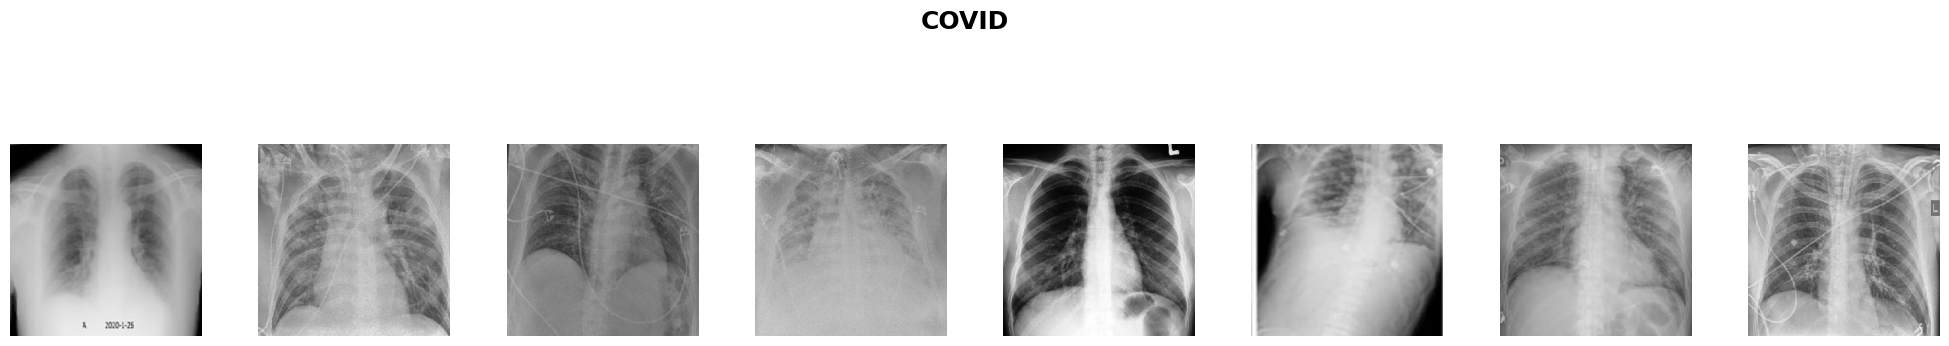

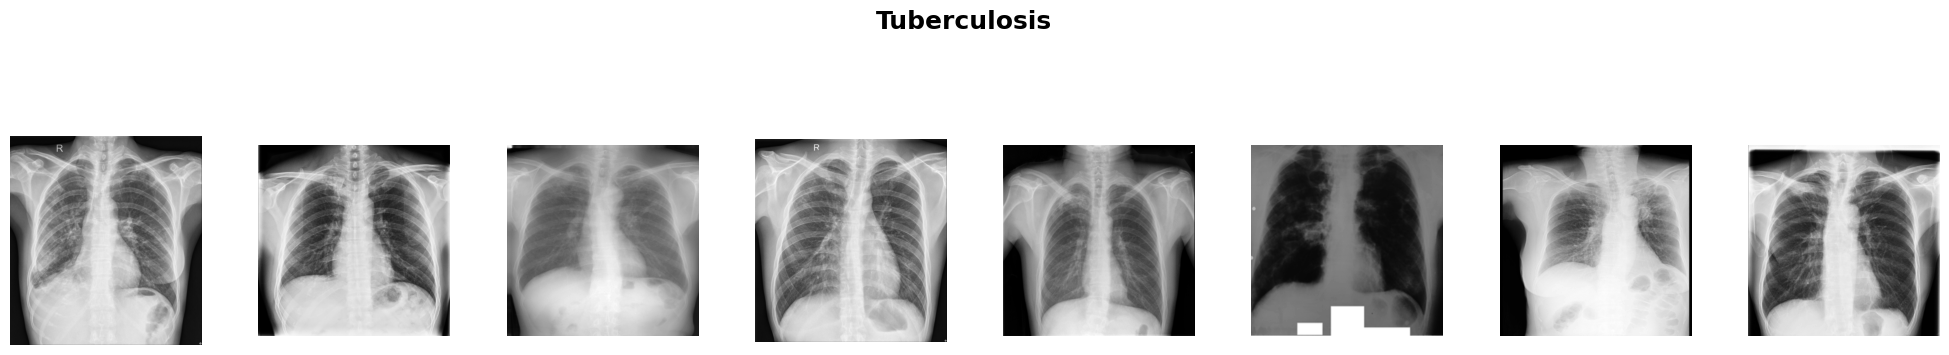

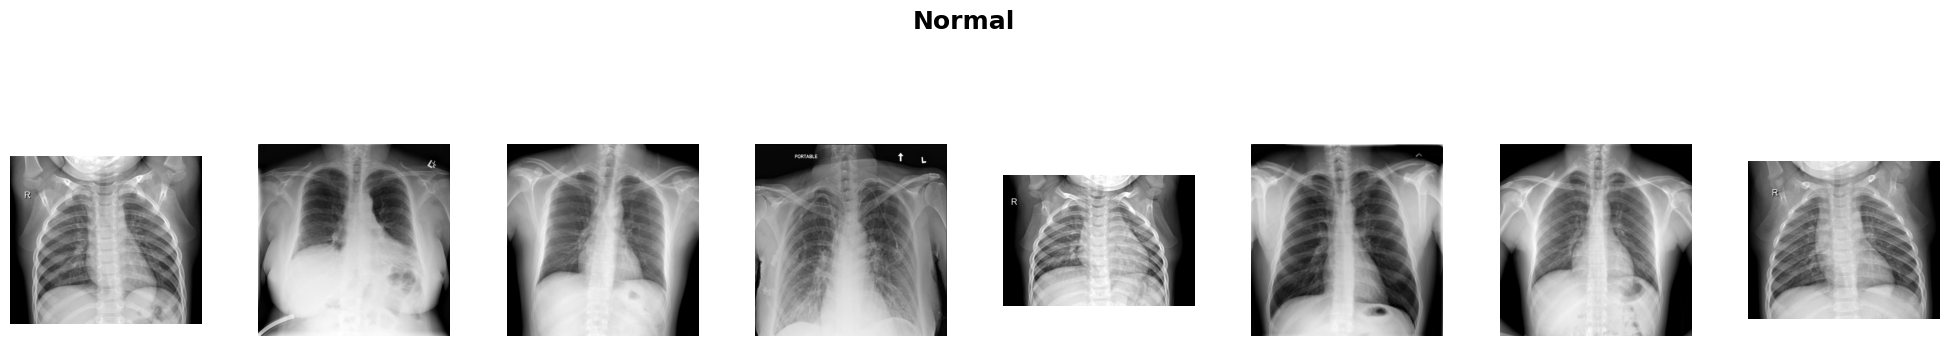

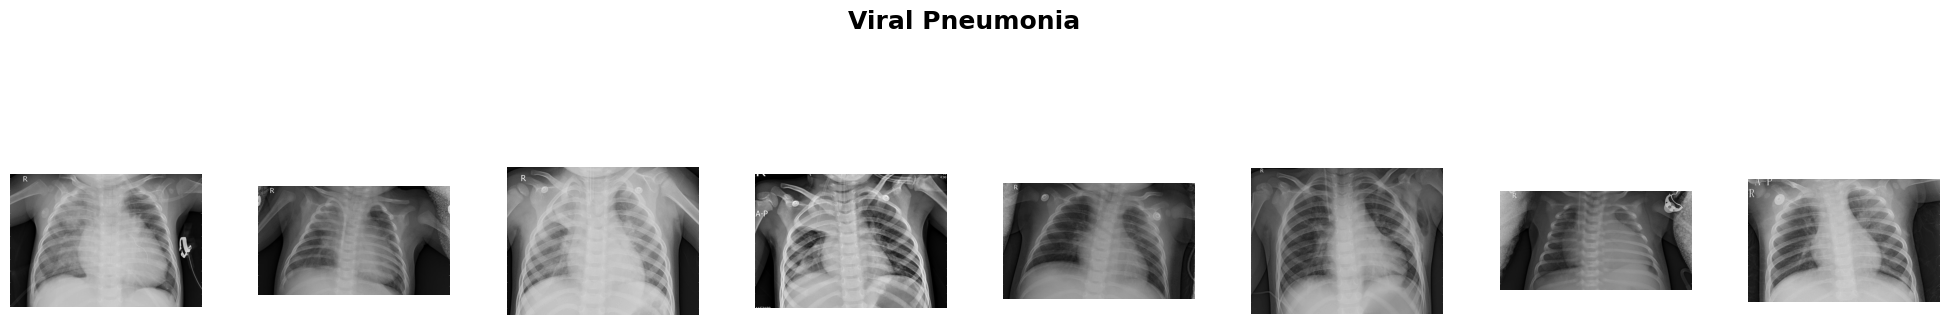

In [48]:
# Define a function to plot a set of images
def plot_images(image_dir, label):
    # Get a list of the filenames in the directory
    filenames = os.listdir(image_dir)
    # Take the first 5 filenames
    filenames = filenames[:8]
    # Plot each image in a subplot
    fig, axs = plt.subplots(1, 8, figsize=(20, 5))
    fig.tight_layout(pad=1)
    fig.suptitle(label, fontsize=18, fontweight="bold")
    for i, filename in enumerate(filenames):
        img_path = os.path.join(image_dir, filename)
        img = plt.imread(img_path)
        axs[i].imshow(img, cmap = 'gray')
        axs[i].axis("off")
    plt.show()

# Plot the images for each set
plot_images(covid_dir, "COVID")
plot_images(Tuberculosis_dir, "Tuberculosis")
plot_images(normal_dir, "Normal")
plot_images(pneumonia_dir, "Viral Pneumonia")

In [49]:
from PIL import Image, ImageStat
import os

def check_image_quality(directory):
    """Check for corrupted, blank, or very low-quality images."""
    bad_images = []
    
    for root, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            try:
                with Image.open(filepath) as img:
                    # Check if image is corrupted
                    img.verify()

                # Reopen to analyze image stats
                with Image.open(filepath) as img:
                    # Check for blank or low-intensity images
                    stat = ImageStat.Stat(img)
                    if max(stat.var) < 10:  # Variance below threshold
                        print(f"Low-quality (nearly blank) image: {filepath}")
                        bad_images.append(filepath)

                    # Check for very small resolution
                    if img.size[0] < 50 or img.size[1] < 50:
                        print(f"Very small resolution image: {filepath}")
                        bad_images.append(filepath)
            except Exception as e:
                print(f"Corrupted image: {filepath} - {e}")
                bad_images.append(filepath)

    return bad_images

# Check quality for all classes
combined_dir = "Dataset/combined"
classes = ["COVID", "Tuberculosis", "NORMAL", "PNEUMONIA"]

for c in classes:
    print(f"Checking quality for class: {c}")
    class_dir = os.path.join(combined_dir, c)
    if os.path.exists(class_dir):
        bad_images = check_image_quality(class_dir)
        print(f"Found {len(bad_images)} bad images in {c}.")
    else:
        print(f"Directory does not exist for class: {c}")


Checking quality for class: COVID
Found 0 bad images in COVID.
Checking quality for class: Tuberculosis
Found 0 bad images in Tuberculosis.
Checking quality for class: NORMAL
Found 0 bad images in NORMAL.
Checking quality for class: PNEUMONIA
Found 0 bad images in PNEUMONIA.


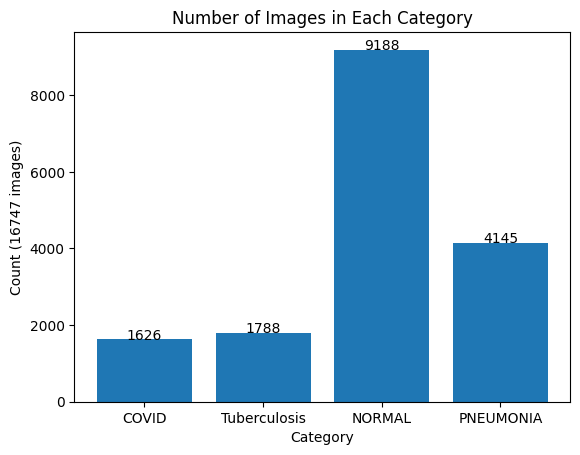

In [50]:
data_labels_1 = ["COVID","Tuberculosis", "NORMAL", "PNEUMONIA"]
plt.bar(data_labels_1, counts)

# Set the title and axis labels
plt.title('Number of Images in Each Category')
plt.xlabel('Category')
plt.ylabel(f'Count ({sum(counts)} images)')

for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center')

# Display the chart
plt.show()

In [55]:
import os
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the paths to the image directories
data_dir = "Dataset/combined"  # Updated to point to the 'combined' folder
classes = ["COVID", "Tuberculosis", "NORMAL", "PNEUMONIA"]
train_dir = "train"
valid_dir = "valid"
test_dir = "test"

# Create train, valid, and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the train, validation, and test ratios
train_ratio = 0.70
valid_ratio = 0.20
test_ratio = 0.10

# Split the data into train, validation, and test sets
for c in classes:
    # Correct the class directory path
    class_dir = os.path.join(data_dir, c)
    
    # Check if the directory exists
    if not os.path.exists(class_dir):
        print(f"Directory {class_dir} does not exist. Skipping...")
        continue

    # Get all filenames from the directory
    filenames = os.listdir(class_dir)

    # Split filenames into train, validation, and test sets
    train_filenames, test_filenames = train_test_split(filenames, test_size=test_ratio, random_state=42)
    train_filenames, valid_filenames = train_test_split(
        train_filenames, test_size=valid_ratio / (train_ratio + valid_ratio), random_state=42
    )

    # Create class subdirectories in train, valid, and test directories if they don't exist
    os.makedirs(os.path.join(train_dir, c), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, c), exist_ok=True)
    os.makedirs(os.path.join(test_dir, c), exist_ok=True)

    # Copy the train images
    for filename in train_filenames:
        src_file = os.path.join(class_dir, filename)
        dst_file = os.path.join(train_dir, c, filename)
        copyfile(src_file, dst_file)

    # Copy the valid images
    for filename in valid_filenames:
        src_file = os.path.join(class_dir, filename)
        dst_file = os.path.join(valid_dir, c, filename)
        copyfile(src_file, dst_file)

    # Copy the test images
    for filename in test_filenames:
        src_file = os.path.join(class_dir, filename)
        dst_file = os.path.join(test_dir, c, filename)
        copyfile(src_file, dst_file)

# Define the image data generators for train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Define the batch size
batch_size = 32

# Create the train, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=batch_size, class_mode="categorical"
)
valid_generator = valid_datagen.flow_from_directory(
    valid_dir, target_size=(224, 224), batch_size=batch_size, class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=batch_size, class_mode="categorical"
)


Found 12033 images belonging to 4 classes.
Found 3594 images belonging to 4 classes.
Found 1790 images belonging to 4 classes.
